# Rekurentne neuronske mreže i vremenske serije

Ovaj primer ilustruje rad sa rekurentnim neuronskim mrežama u analizi vremenskih serija.

U radu će se koristiti podaci meteorološke stanice Maks Plank instituta u Jeni. U periodu od 2009. godine do 2016. godine na svakih 10 minuta merene su vrednosti 14 različitih parametara kao što su temperatura, atmosferski pritisak, vlažnost vazduha, pravac vetra i drugi. Naš zadatak će biti da osmislimo model koji će predvidjati vrednosti `temperature` u toku jednog dana na osnovu nekoliko prethodnih merenja.

Skup podataka se može preuzeti sa [ove](https://www.kaggle.com/stytch16/jena-climate-2009-2016) adrese.

# Setup

In [ ]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils

RANDOM_STATE = 1389
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.use_deterministic_algorithms(False)

In [ ]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bind_gpu(data):
  device = get_device()
  if isinstance(data, (list, tuple)):
    return [bind_gpu(data_elem) for data_elem in data]
  else:
    return data.to(device, non_blocking=True)

def count_parameters(model):
  total_params = sum(p.numel() for p in model.parameters())

  # Iterate through the layers and print their details
  for name, layer in model.named_children():
        num_params = sum(p.numel() for p in layer.parameters())
        print(f"Layer: {name}, Parameters: {num_params}")

  return total_params

# Dataset

In [ ]:
!ls -lht data  # expected size ~42Mb

total 42M
-rw-r--r-- 1 root root 42M Jan  1 17:23 jena_climate_2009_2016.csv


In [ ]:
with open('data/jena_climate_2009_2016.csv', 'r') as f:
  data = f.read()

Ovako pročitani podaci su u tekstualnoj formi i potrebno ih je dalje obraditi. Prvo ćemo izdvojiti linije ovog fajla.

In [ ]:
all_lines = data.split('\n')
number_of_lines = len(all_lines)
number_of_lines

420552

Prva linija sadržaja je zaglavlje sa imenima kolona merenih parametara.

In [ ]:
header = all_lines[0]
print(header)

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"


In [ ]:
header = header.split(',')
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

Parametara ima ukupno 15 uključujući i vreme merenja `'Date Time'`.

In [ ]:
len(header)

15

Preostale linije sadržaja su linije sa podacima.

In [ ]:
lines = all_lines[1:]
lines[1]

'01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10'

Podatke je dalje potrebno prebaciti u numeričku formu. Prilikom prebacivanja vrednosti ćemo ignorisati informaciju o vremenu merenja.

In [ ]:
number_of_features = len(header)-1
number_of_mesurements = len(lines)
float_data = np.zeros((number_of_mesurements, number_of_features))

In [ ]:
for i, line in enumerate(lines):
  values = [float(m) for m in line.split(',')[1:]]
  float_data[i, :] = values

In [ ]:
float_data.shape

(420551, 14)

Matrica sa podacima je `float_data` i dimenzija je `420551 x 14`.

Možemo prikazati kako izgleda grafik promene temeprature u ovom periodu.

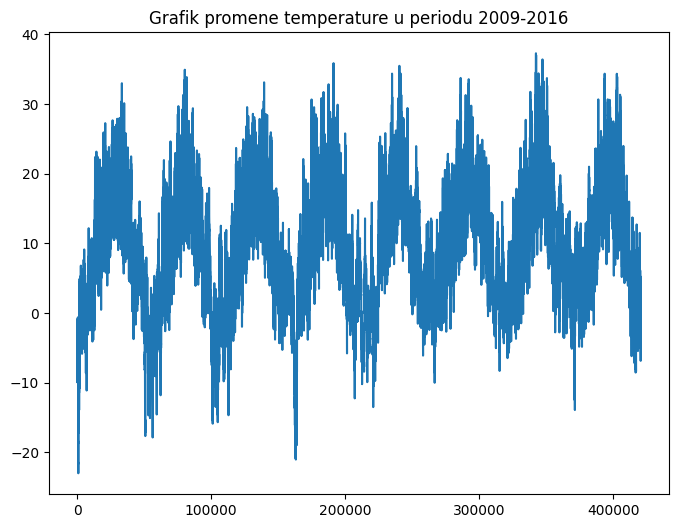

In [ ]:
plt.figure(figsize=(8, 6))
temp = float_data[:, 1]
plt.title('Grafik promene temperature u periodu 2009-2016')
plt.plot(range(0, number_of_mesurements) , temp)
plt.show()

Merenja su vršena na svakih 10 minuta, tj. 6 puta u satu vremena tj. 6x24 = 144 puta u toku jednog dana.

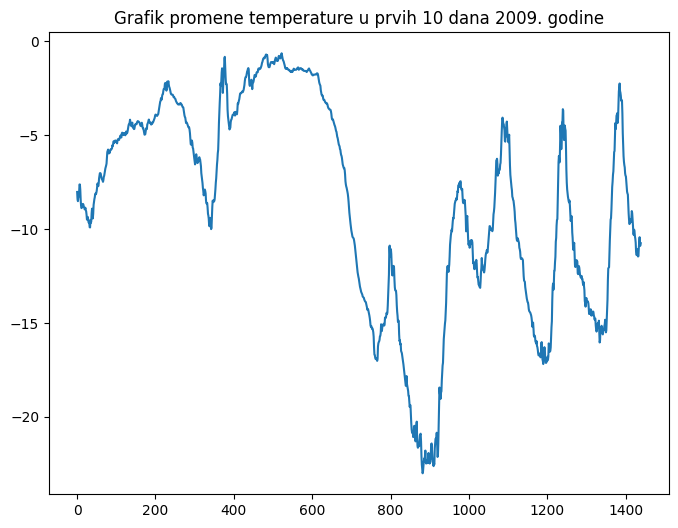

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Grafik promene temperature u prvih 10 dana 2009. godine")
plt.plot(range(0, 1440) , temp[0:1440])
plt.show()

# Train-Validation-Test Split

Kako je potrebno kreirati model koji će predvidjati vrednosti temperature u budućnosti (za 24 sata tj. 144 vrednosti unapred), opredelićemo se za predikcije na osnovu svakog šestog merenja (jednom u satu) u protekllih 720 merenja (5 dana). Motivacija za preskakanje nekih vrednosti prethodnih merenja je nepromenljivost temperature u kratkim vremenskim periodima kao što je period od 10 minuta.

Broj prethodnih merenja ćemo obeležiti promenljivom `lookback`, a frekvenciju sa kojom će se uzimati prethodna merenja `steps`. Promenljiva `delay` će predstavljati udaljenost trenutka u budućnosti u kojem treba dati ocenu temperature.

In [ ]:
lookback = 720
steps = 6
delay = 144

<img src='assets/jena_dataset.jpg'>

Skupovi za treniranje, validaciju i testiranje treba da sadrže vrednosti merenja sa odgovarajućim vremenskim razmakom i temperature koje su im odgovarale u trenucima u budućnosti. Da bi se održala disjunktnost ovih skupova, merenja će biti birana iz različitih opsega vrednosti određenih svojom donjom i gornjom granicom. Merenja u skupu za treniranje treba da prethode merenjima u validacionom skupa, a ona zajedno, treba da prethode merenjima u skupu za testiranje.

Nadalje sledi funkcija koja vraća odgovarajuće generatore vrednosti. Argumenti ove funkcije su redom:
- `data`: zadati podaci
- `lookback`: broj merenja iz prošlosti koje treba uzeti u obzir
- `delay`: broj merenja u budućnosti za koji treba dati ocene merenja
- `min_index`, `max_index`: vrednosti koje predstavljaju donju i gornju granicu merenja
- `shuffle`: indikator mešanja podataka
- `batch_size`: veličina skupa podataka koje treba generisati
- `step`: korak sa kojim će biti birana merenja iz prošlosti

In [ ]:
number_of_features, float_data.shape

(14, (420551, 14))

In [ ]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):

        # za slucaj da max_index nije zadat, bira se vrednost koja garantuje izbor odgovarajuceg broj predikcija
        if max_index is None:
            max_index = len(data) - delay -1


        # indeks i oznavacava minimalni indeks merenja od kojeg se mogu birati podaci za zeljeni skup
        # izraz garantuje da postoji odgovarajuci broj merenja u proslosti

        i = min_index + lookback

        # U smernicama Keras biblioteke za implementaciju generatorske funkcije stoji:
        # The generator is expected to loop over its data indefinitely.
        while True:

            # generise se odgovarajuci skup indeksa vrednosti merenja:
            # ukupno njih batch_size iz dozvoljenih granica
            if shuffle:
                rows = np.random.randint(low=i, high=max_index, size=batch_size)
            else:
                if i + batch_size >= max_index:
                    i = min_index + lookback
                rows = np.arange(i, min(i + batch_size, max_index))

                i += len(rows)

            # samples niz ce biti skup odgovarajucih merenja
            samples = np.zeros((len(rows), lookback//step, number_of_features))

            # targets niz ce biti skup odgovarajucih predikcija
            targets = np.zeros(len(rows))

            for j, row in enumerate(rows):
                indexes = range(rows[j]-lookback, rows[j], step)
                samples[j] = data[indexes]
                targets[j] = data[rows[j] + delay][1]


            # generator će generisati odgovarajuće uzorke i njihova merenja
            yield torch.tensor(samples).to(torch.float32), torch.tensor(targets).to(torch.float32)

Fiksiraćemo broj instanci iz kojeg se bira skup za treniranje. Pre treniranja izvršićemo standardizaciju podataka.

In [ ]:
number_of_training_data = 200000

mean = float_data[:number_of_training_data].mean(axis=0)
float_data -= mean
std = float_data[:number_of_training_data].std(axis=0)
float_data /= std

Fiksiraćemo i veličinu skupova koje treba generisati. Zatim ćemo pozivom implementirane funkcije kreirati redom generatore skupa za treniranje, skup za validaciju i skup za testiranje.

In [ ]:
batch_size = 64

train_gen = generator(float_data, lookback, delay, min_index=0, max_index=200000, shuffle=True, batch_size=batch_size, step=steps)
val_gen = generator(float_data, lookback, delay, min_index =200001, max_index=300000, shuffle=True, batch_size=batch_size, step=steps)
test_gen = generator(float_data, lookback, delay, min_index=300001, max_index=None, shuffle=True, batch_size=batch_size, step=steps)

In [ ]:
type(train_gen)

generator

In [ ]:
out = train_gen.__next__()
type(out), type(out[0]), type(out[1]), out[0].shape, out[1].shape, out[1]

(tuple,
 torch.Tensor,
 torch.Tensor,
 torch.Size([64, 120, 14]),
 torch.Size([64]),
 tensor([ 0.5335,  1.1514, -1.2028,  0.6849,  0.8735,  0.5674, -0.0200, -1.3315,
          1.4202,  0.2861, -0.8187,  2.2810,  1.2146, -0.3024, -1.3824,  1.2768,
         -1.7088, -0.1601,  1.5343, -0.2697, -0.4843, -1.1790, -0.0449, -0.3985,
          0.5945, -0.0076, -0.4561, -0.7419, -0.4900,  0.6295,  0.0139,  0.1517,
         -0.2550,  0.9424,  0.7402, -0.5261,  0.0862,  1.5693, -0.3375, -0.3894,
         -1.3417,  0.7617, -0.0822,  1.0057, -0.2245, -1.1113, -1.0186,  1.9749,
          0.7154,  1.1616,  0.2703,  1.7580,  1.1751, -1.7868,  0.5843, -0.8074,
         -0.3996, -0.9960,  1.0226, -0.3691, -0.8424, -1.3519, -0.5713,  0.2364]))

# RNN Mreza: 1-st attempt


Naša mreža za predikciju temperature će sadržati jedan rekurentni sloj GRU ćelija veličine 32 sa podrazumevanom hiperboličkom aktivacijom i jedan gusti sloj sa jednom ćelijom (jer mreža radi predikciju temperature) i linearnom aktivacijom.  

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size

        # Define the GRU layer
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)

        # Define the fully connected (linear) layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through the GRU layer
        out, _ = self.gru(x)

        # Take the output from the last step and pass it through the linear layer
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
input_size = number_of_features
hidden_size = 32
output_size = 1
model = GRUModel(input_size, hidden_size, output_size)
bind_gpu(model)
count_parameters(model)

Layer: gru, Parameters: 4608
Layer: fc, Parameters: 33


4641

In [ ]:
def train_regression(model, optimizer, number_of_epochs, train_loader, validation_loader, steps_per_train_epoch=None, val_steps=None):
    device = get_device()

    metrics = {
        'train_loss': [],
        'train_steps': [],
        'val_loss': [],
        'val_steps': [],
    }

    training_steps = 0
    for epoch in range(number_of_epochs):
        model.train()

        for inputs, targets in train_loader:
            if steps_per_train_epoch is not None and batches_processed >= steps_per_train_epoch:
                break  # Exit the loop if the desired number of steps is reached

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = nn.functional.mean_squared_error(outputs.squeeze(), targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            metrics['train_loss'].append(loss.item())
            metrics['train_steps'].append(training_steps)
            training_steps += 1
            batches_processed += 1

        epoch_train_loss = running_loss / batches_processed if steps_per_train_epoch is not None else running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {epoch_train_loss:.4f}")

        if validation_loader:
            model.eval()
            val_running_loss = 0.0
            val_batches_processed = 0

            with torch.no_grad():
                for val_inputs, val_targets in validation_loader:
                    if val_steps is not None and val_batches_processed >= val_steps:
                        break  # Exit the loop if the desired number of validation steps is reached

                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs.squeeze(), val_targets)
                    val_running_loss += val_loss.item()
                    val_batches_processed += 1

            epoch_val_loss = val_running_loss / val_batches_processed if val_steps is not None else val_running_loss / len(validation_loader)
            val_losses.append(epoch_val_loss)
            print(f"Epoch [{epoch + 1}/{number_of_epochs}], Validation Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters())
criterion = nn.L1Loss()

epochs = 20
train_steps_per_epoch=500
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

train_losses, val_losses = train_regression(model, criterion, optimizer, epochs, train_gen, val_gen, steps_per_train_epoch=train_steps_per_epoch, val_steps=val_steps)

Epoch [1/20], Train Loss: 0.3091
Epoch [1/20], Validation Loss: 0.2805
Epoch [2/20], Train Loss: 0.2771
Epoch [2/20], Validation Loss: 0.2827
Epoch [3/20], Train Loss: 0.2661
Epoch [3/20], Validation Loss: 0.2769
Epoch [4/20], Train Loss: 0.2542
Epoch [4/20], Validation Loss: 0.2877
Epoch [5/20], Train Loss: 0.2486
Epoch [5/20], Validation Loss: 0.2962
Epoch [6/20], Train Loss: 0.2436
Epoch [6/20], Validation Loss: 0.2988
Epoch [7/20], Train Loss: 0.2433
Epoch [7/20], Validation Loss: 0.2855
Epoch [8/20], Train Loss: 0.2388
Epoch [8/20], Validation Loss: 0.2921
Epoch [9/20], Train Loss: 0.2384
Epoch [9/20], Validation Loss: 0.2997
Epoch [10/20], Train Loss: 0.2370
Epoch [10/20], Validation Loss: 0.3018
Epoch [11/20], Train Loss: 0.2375
Epoch [11/20], Validation Loss: 0.3063
Epoch [12/20], Train Loss: 0.2419
Epoch [12/20], Validation Loss: 0.2948
Epoch [13/20], Train Loss: 0.2395
Epoch [13/20], Validation Loss: 0.2990
Epoch [14/20], Train Loss: 0.2542
Epoch [14/20], Validation Loss: 0.3

In [ ]:
def plot_regression(train_losses, val_losses):
    epochs = len(train_losses)
    epochs_range = range(epochs)

    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss', linestyle='--', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def evaluate_regression(model, criterion, loader, test_steps=None):
    model.eval()
    total_loss = 0.0
    device = get_device()
    predicted_labels, true_labels = [], []
    batches_processed = 0

    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, labels in loader:
            if test_steps is not None and batches_processed >= test_steps:
                break  # Exit the evaluation loop if the desired number of test steps is reached

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()

            predicted_labels.extend(outputs.squeeze().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            batches_processed += 1

    # Compute regression metrics
    avg_loss = total_loss / batches_processed if test_steps is not None else total_loss / len(loader)
    mse = mean_squared_error(true_labels, predicted_labels)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_labels, predicted_labels)
    r2 = r2_score(true_labels, predicted_labels)

    print(f'Model evaluation on: {loader}')
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return avg_loss, mse, rmse, mae, r2

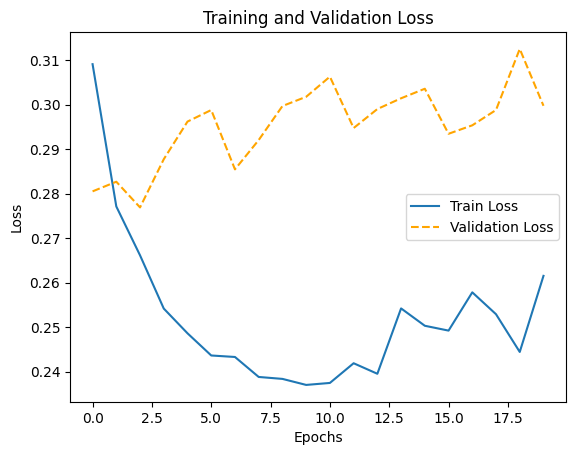

Model evaluation on: <generator object generator at 0x7c0d897eaf10>
Average Loss: 0.3108
MSE: 0.1589
RMSE: 0.3986
MAE: 0.3108
R2 Score: 0.7978


(0.3108483219089416, 0.1589151, 0.3986416, 0.31084833, 0.7978415389462971)

In [ ]:
plot_regression(train_losses, val_losses)
evaluate_regression(model, criterion, test_gen, test_steps)

# RNN Mreza: 2nd attempt

In [ ]:
input_size = number_of_features
hidden_size = 32
output_size = 1
model = GRUModel(input_size, hidden_size, output_size)
bind_gpu(model)
count_parameters(model)

Layer: gru, Parameters: 4608
Layer: fc, Parameters: 33


4641

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

epochs = 20
train_steps_per_epoch=500
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

train_losses, val_losses = train_regression(model, criterion, optimizer, epochs, train_gen, val_gen, steps_per_train_epoch=train_steps_per_epoch, val_steps=val_steps)

Epoch [1/20], Train Loss: 0.1790
Epoch [1/20], Validation Loss: 0.1250
Epoch [2/20], Train Loss: 0.1398
Epoch [2/20], Validation Loss: 0.1217
Epoch [3/20], Train Loss: 0.1352
Epoch [3/20], Validation Loss: 0.1203
Epoch [4/20], Train Loss: 0.1291
Epoch [4/20], Validation Loss: 0.1158
Epoch [5/20], Train Loss: 0.1277
Epoch [5/20], Validation Loss: 0.1184
Epoch [6/20], Train Loss: 0.1205
Epoch [6/20], Validation Loss: 0.1165
Epoch [7/20], Train Loss: 0.1169
Epoch [7/20], Validation Loss: 0.1172
Epoch [8/20], Train Loss: 0.1134
Epoch [8/20], Validation Loss: 0.1211
Epoch [9/20], Train Loss: 0.1080
Epoch [9/20], Validation Loss: 0.1210
Epoch [10/20], Train Loss: 0.1026
Epoch [10/20], Validation Loss: 0.1284
Epoch [11/20], Train Loss: 0.1003
Epoch [11/20], Validation Loss: 0.1238
Epoch [12/20], Train Loss: 0.0954
Epoch [12/20], Validation Loss: 0.1322
Epoch [13/20], Train Loss: 0.0911
Epoch [13/20], Validation Loss: 0.1331
Epoch [14/20], Train Loss: 0.0884
Epoch [14/20], Validation Loss: 0.1

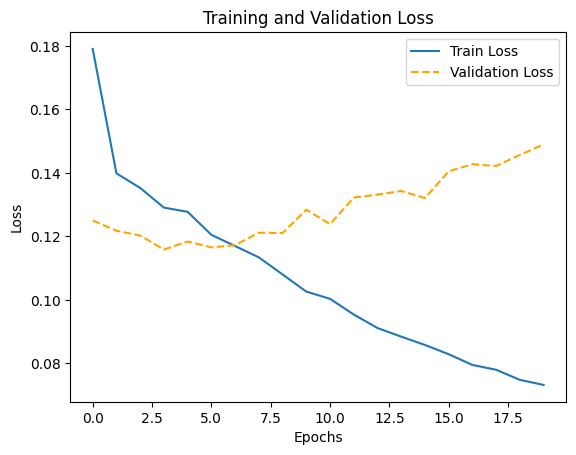

Model evaluation on: <generator object generator at 0x7c0d897eaf10>
Average Loss: 0.1570
MSE: 0.1570
RMSE: 0.3962
MAE: 0.3131
R2 Score: 0.8011


(0.156997026107473, 0.15699701, 0.3962285, 0.3131107, 0.801100882269167)

In [ ]:
plot_regression(train_losses, val_losses)
evaluate_regression(model, criterion, test_gen, test_steps)

# RNN Mreza: 3rd attempt

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.1, residual_connections=False):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.residual_connections = residual_connections

        # Define multiple GRU layers
        self.gru_layers = nn.ModuleList([
            nn.GRU(input_size if i == 0 else hidden_size, hidden_size, batch_first=True) for i in range(num_layers)
        ])

        # Dropout between GRU layers
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        for i, layer in enumerate(self.gru_layers):
            out, _ = layer(x)
            x = self.dropout(out)
            if self.residual_connections:
                x += out  # residual connection between layers

        out = self.fc(x[:, -1, :])
        return out

In [ ]:
input_size = number_of_features
hidden_size = 64
output_size = 1
model = GRUModel(input_size, hidden_size, output_size, num_layers=3, dropout=0.5)
bind_gpu(model)
count_parameters(model)

Layer: gru_layers, Parameters: 65280
Layer: dropout, Parameters: 0
Layer: fc, Parameters: 65


65345

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

epochs = 20
train_steps_per_epoch=500
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

train_losses, val_losses = train_regression(model, criterion, optimizer, epochs, train_gen, val_gen, steps_per_train_epoch=train_steps_per_epoch, val_steps=val_steps)

Epoch [1/20], Train Loss: 0.2101
Epoch [1/20], Validation Loss: 0.1294
Epoch [2/20], Train Loss: 0.1717
Epoch [2/20], Validation Loss: 0.1212
Epoch [3/20], Train Loss: 0.1564
Epoch [3/20], Validation Loss: 0.1250
Epoch [4/20], Train Loss: 0.1484
Epoch [4/20], Validation Loss: 0.1211
Epoch [5/20], Train Loss: 0.1440
Epoch [5/20], Validation Loss: 0.1253
Epoch [6/20], Train Loss: 0.1378
Epoch [6/20], Validation Loss: 0.1252
Epoch [7/20], Train Loss: 0.1326
Epoch [7/20], Validation Loss: 0.1226
Epoch [8/20], Train Loss: 0.1278
Epoch [8/20], Validation Loss: 0.1324
Epoch [9/20], Train Loss: 0.1219
Epoch [9/20], Validation Loss: 0.1350
Epoch [10/20], Train Loss: 0.1159
Epoch [10/20], Validation Loss: 0.1330
Epoch [11/20], Train Loss: 0.1143
Epoch [11/20], Validation Loss: 0.1404
Epoch [12/20], Train Loss: 0.1064
Epoch [12/20], Validation Loss: 0.1552
Epoch [13/20], Train Loss: 0.1042
Epoch [13/20], Validation Loss: 0.1474
Epoch [14/20], Train Loss: 0.0978
Epoch [14/20], Validation Loss: 0.1

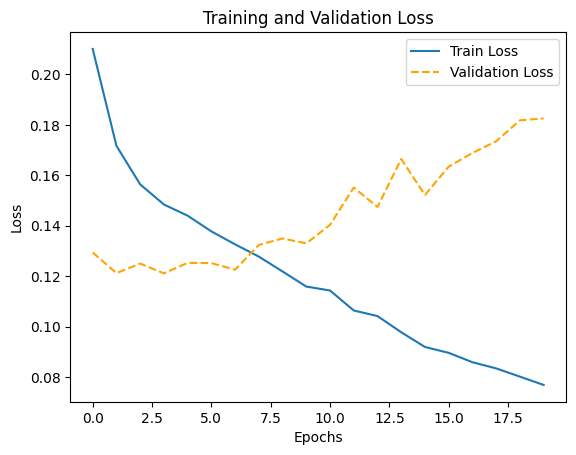

Model evaluation on: <generator object generator at 0x7c0d897eaf10>
Average Loss: 0.1975
MSE: 0.1975
RMSE: 0.4444
MAE: 0.3507
R2 Score: 0.7479


(0.19747172337837327, 0.19747172, 0.4443779, 0.35065562, 0.747943836710748)

In [ ]:
plot_regression(train_losses, val_losses)
evaluate_regression(model, criterion, test_gen, test_steps)

# RNN Mreza: 4th attempt

In [ ]:
input_size = number_of_features
hidden_size = 24
output_size = 1
model = GRUModel(input_size, hidden_size, output_size, num_layers=2, dropout=0.5, residual_connections=True)
bind_gpu(model)
count_parameters(model)

Layer: gru_layers, Parameters: 6480
Layer: dropout, Parameters: 0
Layer: fc, Parameters: 25


6505

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.L1Loss()

epochs = 20
train_steps_per_epoch=500
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

train_losses, val_losses = train_regression(model, criterion, optimizer, epochs, train_gen, val_gen, steps_per_train_epoch=train_steps_per_epoch, val_steps=val_steps)

Epoch [1/20], Train Loss: 0.3475
Epoch [1/20], Validation Loss: 0.2821
Epoch [2/20], Train Loss: 0.3184
Epoch [2/20], Validation Loss: 0.2755
Epoch [3/20], Train Loss: 0.3119
Epoch [3/20], Validation Loss: 0.2735
Epoch [4/20], Train Loss: 0.3045
Epoch [4/20], Validation Loss: 0.2728
Epoch [5/20], Train Loss: 0.3028
Epoch [5/20], Validation Loss: 0.2656
Epoch [6/20], Train Loss: 0.2961
Epoch [6/20], Validation Loss: 0.2648
Epoch [7/20], Train Loss: 0.2934
Epoch [7/20], Validation Loss: 0.2666
Epoch [8/20], Train Loss: 0.2900
Epoch [8/20], Validation Loss: 0.2719
Epoch [9/20], Train Loss: 0.2840
Epoch [9/20], Validation Loss: 0.2770
Epoch [10/20], Train Loss: 0.2829
Epoch [10/20], Validation Loss: 0.2666
Epoch [11/20], Train Loss: 0.2824
Epoch [11/20], Validation Loss: 0.2702
Epoch [12/20], Train Loss: 0.2809
Epoch [12/20], Validation Loss: 0.2641
Epoch [13/20], Train Loss: 0.2746
Epoch [13/20], Validation Loss: 0.2662
Epoch [14/20], Train Loss: 0.2731
Epoch [14/20], Validation Loss: 0.2

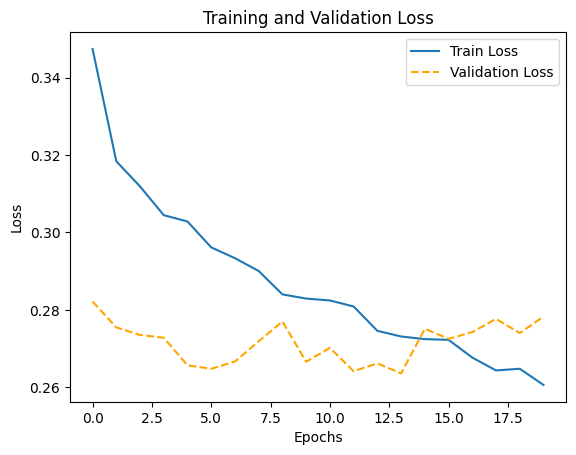

Model evaluation on: <generator object generator at 0x7c0d897eaf10>
Average Loss: 0.2947
MSE: 0.1399
RMSE: 0.3740
MAE: 0.2947
R2 Score: 0.8215


(0.29468832805784595, 0.13986512, 0.37398544, 0.29468834, 0.8215374898901666)

In [ ]:
plot_regression(train_losses, val_losses)
evaluate_regression(model, criterion, test_gen, test_steps)

# RNN Mreza: 5th attempt

In [ ]:
input_size = number_of_features
hidden_size = 16
output_size = 1
model = GRUModel(input_size, hidden_size, output_size, num_layers=3, dropout=0.5, residual_connections=True)
bind_gpu(model)
count_parameters(model)

Layer: gru_layers, Parameters: 4800
Layer: dropout, Parameters: 0
Layer: fc, Parameters: 17


4817

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

epochs = 20
train_steps_per_epoch=500
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

train_losses, val_losses = train_regression(model, criterion, optimizer, epochs, train_gen, val_gen, steps_per_train_epoch=train_steps_per_epoch, val_steps=val_steps)

Epoch [1/20], Train Loss: 0.2207
Epoch [1/20], Validation Loss: 0.1347
Epoch [2/20], Train Loss: 0.1752
Epoch [2/20], Validation Loss: 0.1298
Epoch [3/20], Train Loss: 0.1665
Epoch [3/20], Validation Loss: 0.1274
Epoch [4/20], Train Loss: 0.1569
Epoch [4/20], Validation Loss: 0.1252
Epoch [5/20], Train Loss: 0.1518
Epoch [5/20], Validation Loss: 0.1220
Epoch [6/20], Train Loss: 0.1506
Epoch [6/20], Validation Loss: 0.1316
Epoch [7/20], Train Loss: 0.1452
Epoch [7/20], Validation Loss: 0.1287
Epoch [8/20], Train Loss: 0.1416
Epoch [8/20], Validation Loss: 0.1284
Epoch [9/20], Train Loss: 0.1399
Epoch [9/20], Validation Loss: 0.1249
Epoch [10/20], Train Loss: 0.1373
Epoch [10/20], Validation Loss: 0.1235
Epoch [11/20], Train Loss: 0.1343
Epoch [11/20], Validation Loss: 0.1281
Epoch [12/20], Train Loss: 0.1313
Epoch [12/20], Validation Loss: 0.1400
Epoch [13/20], Train Loss: 0.1319
Epoch [13/20], Validation Loss: 0.1270
Epoch [14/20], Train Loss: 0.1301
Epoch [14/20], Validation Loss: 0.1

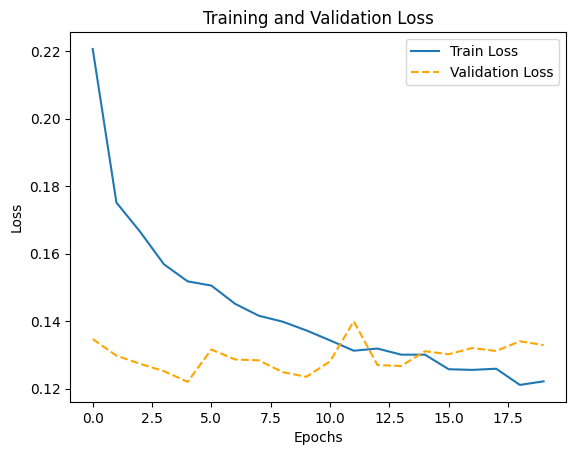

Model evaluation on: <generator object generator at 0x7c0d895fcdd0>
Average Loss: 0.1388
MSE: 0.1388
RMSE: 0.3726
MAE: 0.2955
R2 Score: 0.8222


(0.1388168832502113, 0.13881688, 0.37258136, 0.29551557, 0.8222181695224597)

In [ ]:
plot_regression(train_losses, val_losses)
evaluate_regression(model, criterion, test_gen, test_steps)

# Zadatak:

1. Prodiskutovati trenirane modele, njihove krive ucenja (training i validation krive) i rezultate koje su ostvarili na test skupu.

2. Gde je doslo do preprilagodjavanja i zasto?

3. Dizajnirati i trenirati najbolji model pouceni iskustvima izvedenih treninga.